In [26]:
from zumi.util.camera import Camera
from zumi.zumi import Zumi

import cv2
import PIL.Image
import IPython.display
import time
import math
import pyzbar.pyzbar as pyzbar

import numpy as np

width = 80*2 
height = 64*2

length_of_qr = 3
area_of_qr = length_of_qr**2

def find_qr_area(frame):
    # Run a function that looks for codes in that frame
    decodedObjects = pyzbar.decode(frame) 
    
    # If the code finds more than one code...
    if len(decodedObjects) > 0:
        
        #only look at the first QR code in the list
        obj = decodedObjects[0] 
        print("detected QR ")
        width = obj.rect[2]
        heigt = obj.rect[3]
        area_of_qr = obj.rect[2]*obj.rect[3]
        return area_of_qr
    else:
        return -1
 
def calc_distance(area_detected,area_of_object):
    #cant see beyond 10 inches and below 3 inches
    #when you are below 4 inches the area is too big
    #for the QR code to be seen properly
    #when you are too far away 
    
    #print the area detected
    print("area detected ",area_detected, " pixels^2")

    if area_detected:
        k = 0.96 #some constant which we can vary to get better results
        #this equation has been empirically found to work
        distance = ( k*(area_of_object*width*height)/area_detected )**(1/2)
        
    else:
        distance = 0
    print("predicted distance ",distance ," inches")
    return distance  

In [56]:
try: 
    camera = Camera(width,height)
    camera.start_camera()
    while True:
        time_start = time.time()
        image = camera.capture()
        area = find_qr_area(image)
        distance = calc_distance(area,area_of_qr)
        
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # Convert it to gray
        ret,black_white = cv2.threshold(gray,100,255,cv2.THRESH_BINARY)
        #IPython.display.display(PIL.Image.fromarray(black_white))
        
        print("Frames per second ",1/(time.time()-time_start))
        IPython.display.clear_output(wait=True) 

finally:
    camera.close()
    print("done")

Closing PiCamera
done


PiCameraValueError: Incorrect buffer length for resolution 160x128

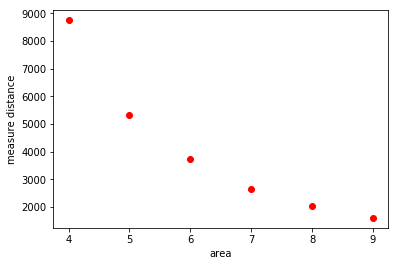

In [51]:
#here are some measurements you can make
#using a rule and printing the area of pixels

'''
Some data of the area detected and the measured distance
the resolution of the camera is 160 by 128 pixels
8747 pix area @ 4 inches
5329 pix area @ 5 inches
3721 pix area @ 6 inches
2652 pix area @ 7 inches
2025 pix area @ 8 inches
1600 pix area @ 9 inches
'''

#area of pixels
area_list = [8747,5329,3721,2652,2025,1600]

#the distance in inches measured
distance_list = [4,5,6,7,8,9]


plt.plot(distance_list,area_list,'ro')
plt.ylabel('measure area')
plt.xlabel('distance')
plt.show()


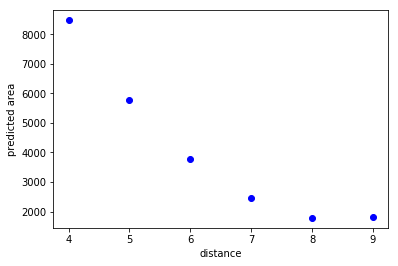

This is the equation that outputs area depending on the distance input
x is the distance
------------------------------------------
       2
337.3 x - 5720 x + 2.596e+04
------------------------------------------
area our model predicts at 9 inches  1799.821428571322
area actually measured at 9 inches  1600


In [55]:
import matplotlib
import matplotlib.pyplot as plt

#we will find the equation that best fits the data we have collected
degree = 2
#( x, y, the order of the polynomials)
weights = np.polyfit(distance_list,area_list, degree)
pred_area_list = []
for distance in distance_list:
    area_pred = weights[0]*(distance)**2 + weights[1]*(distance) + weights[2] 
    pred_area_list.append(area_pred)

plt.plot(distance_list,pred_area_list,'bo')
plt.ylabel('predicted area')
plt.xlabel('distance')
plt.show()    
    
#this is the equation where
#x/input is distance and
#y/output is the area
model = np.poly1d(weights)
print("This is the equation that outputs area depending on the distance input")
print("x is the distance")
print("------------------------------------------")
print(model)
print("------------------------------------------")

#lets try to predict the area we would detect at 9 inches
distance =  9
area_pred = weights[0]*(distance)**2 + weights[1]*(distance) + weights[2] 

print("area our model predicts at 9 inches ",area_pred)
print("area actually measured at 9 inches ",area_list[5])
